In [1]:


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import cv2
import keras
from numpy import random

import tensorflow as tf

# import tensorflow_datasets as tfds
from matplotlib import pyplot as plt
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Flatten, Conv2D
from keras.layers import MaxPooling2D, BatchNormalization
from keras.optimizers import SGD
import np_utils
from keras.applications import MobileNet, VGG16, ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import precision_score, recall_score, accuracy_score
from sklearn.metrics import classification_report ,confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import seaborn as sns


import os



* **Directory of dataset**

In [2]:
# Directory of train, validation and test

train_folder = "Data/train/"
valid_folder = "Data/valid/"
test_folder = "Data/test/"


In [3]:
input_shape = (224,224,3)
num_classes = 4

train_datagen = ImageDataGenerator(
    dtype='float32',
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False
)
val_datagen = ImageDataGenerator(
    dtype='float32',

)
test_datagen = ImageDataGenerator(
    dtype='float32',
)

train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
)


test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
    shuffle = False,
)
validation_generator = val_datagen.flow_from_directory(
    valid_folder,
    target_size=(224,224),
    batch_size=64,
    class_mode='categorical',
)

Found 613 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
Found 72 images belonging to 4 classes.


# SERES_VGG16

Integrating the SE Block into the Residual Block and Incorporating it into the Last Two Output Layers of a Pre-trained VGG16 Model

In [4]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add, Flatten, Dense, GlobalAveragePooling2D, Reshape, Multiply

def squeeze_excitation_block(input, ratio=16):
    init = input
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def residual_block(x, filters, kernel_size, stride):
    shortcut = x
    x = Conv2D(filters, kernel_size, strides=stride, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Conv2D(filters, kernel_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = squeeze_excitation_block(x)
    x = Add()([x, shortcut])
    x = Activation('relu')(x)
    return x

input_tensor = Input(shape=(224, 224, 3))
vgg16 = VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor)

x = vgg16.layers[-1].output
x = residual_block(x, 512, 3, 1)
x = residual_block(x, 512, 3, 1)
x = BatchNormalization()(x)
x = Flatten()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
predictions = Dense(4, activation='softmax')(x)
model = Model(inputs=input_tensor, outputs=predictions)

optimizer = tf.keras.optimizers.SGD()
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

epochs = 50
history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=epochs,
    verbose=1
)

C:\Program Files\Python310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 334s 33s/step - accuracy: 0.3832 - loss: 1.6112 - val_accuracy: 0.1806 - val_loss: 16.9665
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 324s 32s/step - accuracy: 0.4415 - loss: 1.8199 - val_accuracy: 0.1806 - val_loss: 8.7309
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 367s 37s/step - accuracy: 0.5172 - loss: 1.0211 - val_accuracy: 0.1806 - val_loss: 4.3212
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 320s 32s/step - accuracy: 0.5401 - loss: 0.9231 - val_accuracy: 0.1806 - val_loss: 1.8922
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 320s 32s/step - accuracy: 0.6028 - loss: 0.8759 - val_accuracy: 0.1806 - val_loss: 3.4289
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 321s 32s/step - accuracy: 0.6751 - loss: 0.7587 - val_accuracy: 0.2222 - val_loss: 2.7506
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 320s 32s/step - accuracy: 0.6751 - loss: 0.7043 - val_accuracy: 0.2778 - val_loss: 1.7424
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 320s 32s/step - accuracy: 0.6207 - loss: 0.7847 - val_accuracy: 0

In [5]:
test_loss, test_accuracy = model.evaluate(test_generator)
print('Test accuracy:', test_accuracy)

5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step - accuracy: 0.8657 - loss: 0.5259
Test accuracy: 0.8698412775993347


5/5 ━━━━━━━━━━━━━━━━━━━━ 32s 6s/step


Confusion Matrix:
 [[97 16  5  2]
 [ 0 51  0  0]
 [ 0  1 53  0]
 [ 6 11  0 73]]


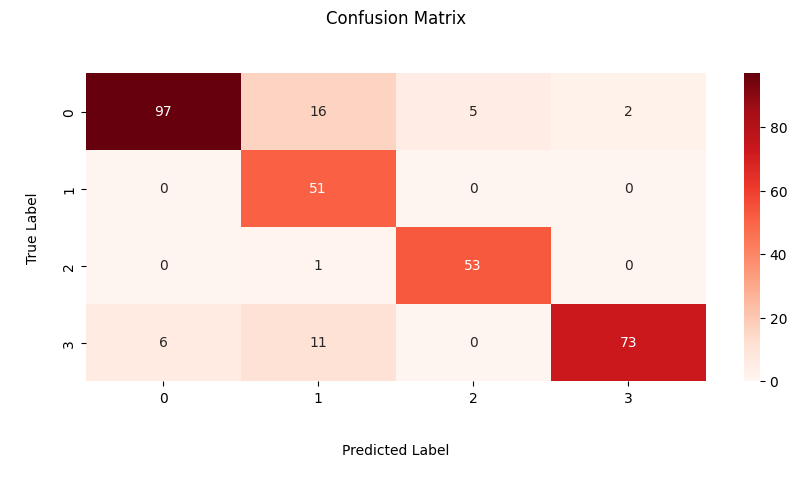

In [7]:
num_test_samples = len(test_generator)
num_classes = len(test_generator.class_indices)
predicted_probabilities = model.predict(test_generator, steps=num_test_samples)
predicted_labels = np.argmax(predicted_probabilities, axis=1)
true_labels = test_generator.classes
cm = confusion_matrix(true_labels, predicted_labels)
print("\n\nConfusion Matrix:\n", cm)

plt.figure(figsize=(10,4))
sns.heatmap(cm, annot=True, fmt='g', cmap='Reds')
plt.xlabel('\n\nPredicted Label\n')
plt.ylabel('\nTrue Label\n')
plt.title('Confusion Matrix\n\n')
plt.show()

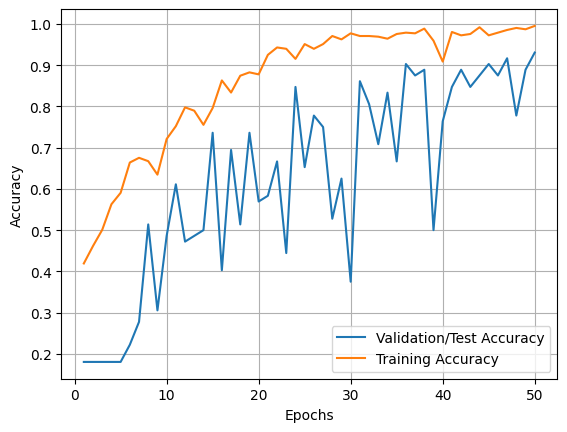

In [8]:
history_dict = history.history

acc_values = history_dict['accuracy']
val_acc_values = history_dict['val_accuracy']
epochs = range(1, len(acc_values) + 1)

line1 = plt.plot(epochs, val_acc_values, label = 'Validation/Test Accuracy')
line2 = plt.plot(epochs, acc_values, label = 'Training Accuracy')

# plt.setp(line1)
# plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.grid(True)
plt.legend()
plt.show()

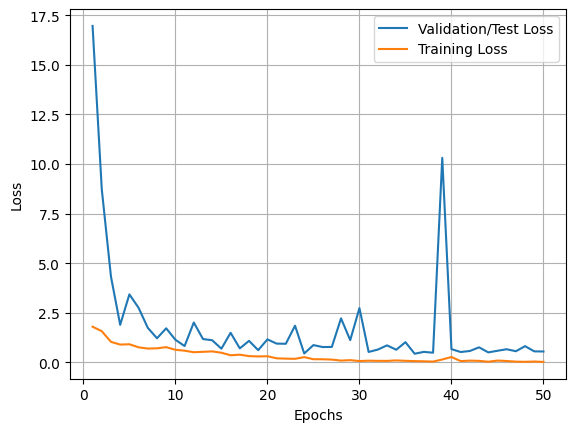

In [9]:
history_dict = history.history

loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

line1 = plt.plot(epochs, val_loss_values, label = 'Validation/Test Loss')
line2 = plt.plot(epochs, loss_values, label = 'Training Loss')

# plt.setp(line1)
# plt.setp(line2)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.grid(True)
plt.legend()
plt.show()

In [10]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       0.94      0.81      0.87       120
           1       0.65      1.00      0.78        51
           2       0.91      0.98      0.95        54
           3       0.97      0.81      0.88        90

    accuracy                           0.87       315
   macro avg       0.87      0.90      0.87       315
weighted avg       0.90      0.87      0.87       315



In [9]:
report = classification_report(true_labels, predicted_labels)
print(report)

              precision    recall  f1-score   support

           0       1.00      0.86      0.92       120
           1       0.72      1.00      0.84        51
           2       0.98      0.98      0.98        54
           3       0.97      0.93      0.95        90

    accuracy                           0.92       315
   macro avg       0.92      0.94      0.92       315
weighted avg       0.94      0.92      0.93       315

